C:\Users\Eier\AppData\Local\Temp\ipykernel_20108\926701219.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("cleandata.csv", parse_dates=["Date"], dayfirst=True)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\AppData\Local\Temp\ipykernel_20108\926701219.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by 

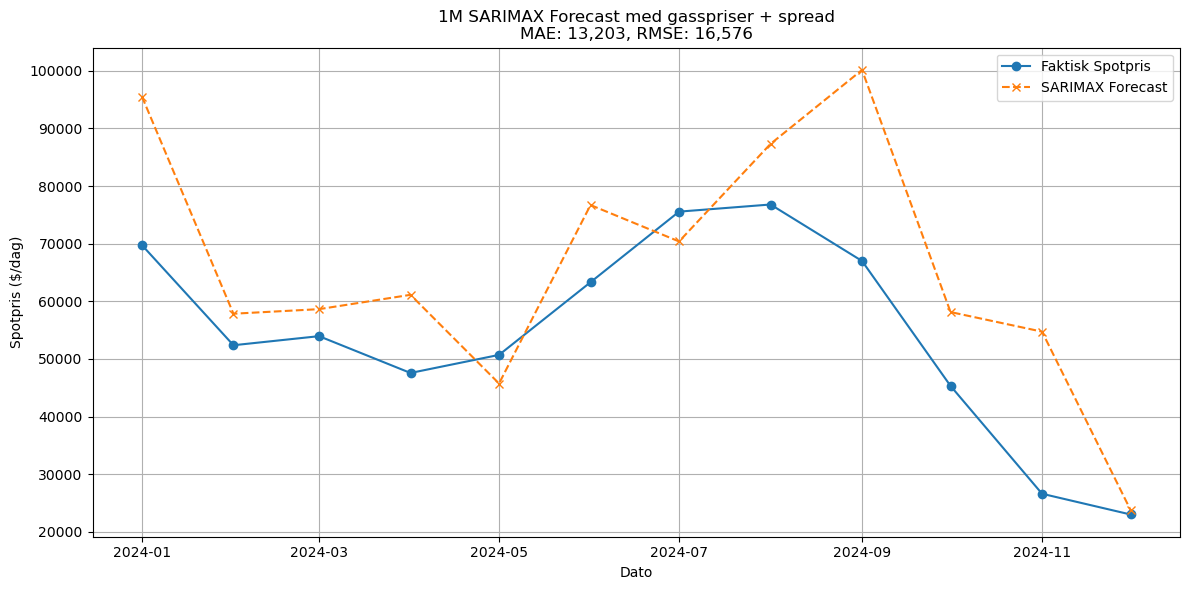

,MAE,RMSE
Month,,
January,25781.67,25781.67
February,5469.54,5469.54
March,4687.48,4687.48
April,13563.54,13563.54
May,4968.11,4968.11
June,13394.57,13394.57
July,5174.75,5174.75
August,10519.48,10519.48
September,33150.52,33150.52


In [80]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# === 1. Load and clean data ===
df = pd.read_csv("cleandata.csv", parse_dates=["Date"], dayfirst=True)
df.set_index("Date", inplace=True)

# Clean column names
df.columns = df.columns.str.replace('\n', ' ', regex=True).str.strip()

# Rename key columns for easier reference
df = df.rename(columns={
    'LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)': 'Spot_Rate',
    'Global price of Natural Gas, Asia (start month, MMBTU)': 'JKM',
    'Global price of Natural Gas, EU (start month, MMBTU)': 'TTF',
    'Global price of Natural Gas, US Henry Hub (start month, MMBTU)': 'NBP'
})

# === 2. Set up forecast config ===
target = "Spot_Rate"
exog_vars = ["JKM", "TTF", "NBP", "Spread EU-US", "Spread ASIA-US", "Spread ASIA-EU"]
order = (1, 1, 2)
seasonal_order = (1, 0, 0, 12)
forecast_dates = pd.date_range(start="2024-01-01", end="2024-12-01", freq="MS")

forecasts = []
actuals = []
month_labels = []

# === 3. Rolling 1M SARIMAX forecast with log-transform ===
for forecast_date in forecast_dates:
    train_end = forecast_date - pd.DateOffset(months=1)
    train_df = df[:train_end]
    test_df = df.loc[forecast_date:forecast_date]

    if test_df.empty or train_df[exog_vars].isnull().any().any():
        continue

    log_train_target = np.log(train_df[target].dropna())
    exog_train = train_df.loc[log_train_target.index, exog_vars]
    exog_test = test_df[exog_vars]

    model = SARIMAX(
        log_train_target,
        exog=exog_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    forecast_log = model.forecast(steps=1, exog=exog_test)
    forecast = np.exp(forecast_log)[0]
    actual = test_df[target].values[0]

    forecasts.append(forecast)
    actuals.append(actual)
    month_labels.append(forecast_date.strftime("%B"))

# === 4. Overall evaluation and plot ===
dates = forecast_dates[:len(forecasts)]
mae = mean_absolute_error(actuals, forecasts)
rmse = mean_squared_error(actuals, forecasts, squared=False)

plt.figure(figsize=(12, 6))
plt.plot(dates, actuals, marker='o', label="Faktisk Spotpris")
plt.plot(dates, forecasts, marker='x', linestyle='--', label="SARIMAX Forecast")
plt.title(f"1M SARIMAX Forecast med gasspriser + spread\nMAE: {int(mae):,}, RMSE: {int(rmse):,}")
plt.xlabel("Dato")
plt.ylabel("Spotpris ($/dag)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 5. Monthly MAE and RMSE ===
df_eval = pd.DataFrame({
    "Month": month_labels,
    "Forecast": forecasts,
    "Actual": actuals
})
df_eval["Abs_Error"] = abs(df_eval["Forecast"] - df_eval["Actual"])
df_eval["Sq_Error"] = (df_eval["Forecast"] - df_eval["Actual"]) ** 2

monthly_errors = df_eval.groupby("Month").agg(
    MAE=("Abs_Error", "mean"),
    RMSE=("Sq_Error", lambda x: np.sqrt(np.mean(x)))
).reindex([
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
])

monthly_errors_rounded = monthly_errors.round(2)
display(monthly_errors_rounded)


C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("

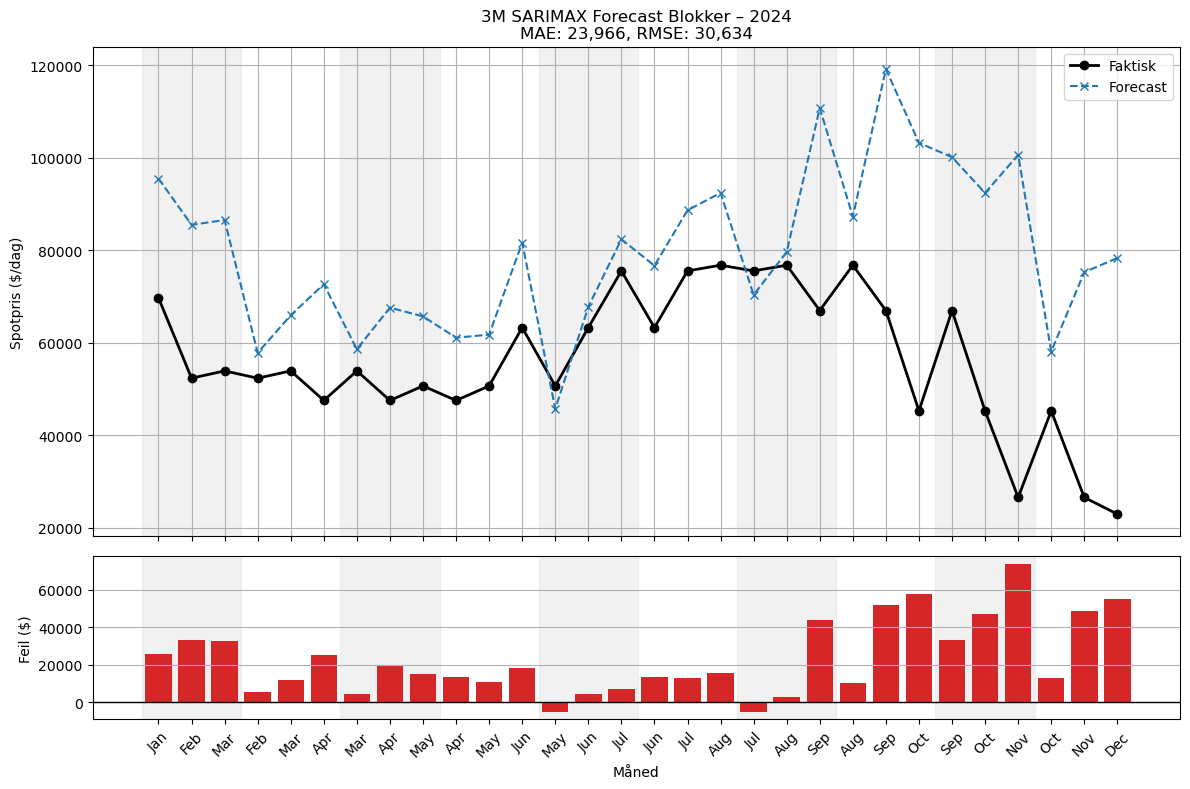

,MAE,RMSE
BlockStart,,
January,30512.36,30695.95
February,14209.14,16390.07
March,13259.64,14723.65
April,14340.80,14657.28
May,5429.79,5523.25
June,14044.07,14089.15
July,17261.30,25485.70
August,40219.57,45432.48
September,51430.74,54158.98


In [84]:
# === 1. Forecast configuration ===
forecast_start_dates = pd.date_range(start="2024-01-01", end="2024-10-01", freq="MS")

forecasts_3m = []
actuals_3m = []
forecast_months_3m = []
block_start_months = []  # brukes til korrekt gruppering

# === 2. Rolling 3M SARIMAX forecast with log-transform ===
for start_date in forecast_start_dates:
    train_end = start_date - pd.DateOffset(months=1)
    train_df = df[:train_end]
    forecast_period = pd.date_range(start=start_date, periods=3, freq="MS")

    if not set(forecast_period).issubset(df.index):
        break

    actual = df.loc[forecast_period, target].dropna()
    if len(actual) < 3:
        break

    log_train_target = np.log(train_df[target].dropna())
    exog_train = train_df.loc[log_train_target.index, exog_vars]
    exog_test = df.loc[forecast_period, exog_vars]

    model = SARIMAX(
        log_train_target,
        exog=exog_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    forecast_log = model.forecast(steps=3, exog=exog_test)
    forecast = np.exp(forecast_log)

    forecasts_3m.extend(forecast)
    actuals_3m.extend(actual.values)
    forecast_months_3m.extend(forecast_period)

    # Registrer blokkmåned 3 ganger (en gang per prediksjon i blokken)
    block_start_months.extend([start_date.strftime("%B")] * 3)

# === 3. Evaluer per blokk (startmåned) ===
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

df_eval_3m = pd.DataFrame({
    "BlockStart": block_start_months,
    "Forecast": forecasts_3m,
    "Actual": actuals_3m
})
df_eval_3m["Abs_Error"] = abs(df_eval_3m["Forecast"] - df_eval_3m["Actual"])
df_eval_3m["Sq_Error"] = (df_eval_3m["Forecast"] - df_eval_3m["Actual"]) ** 2

monthly_block_errors = df_eval_3m.groupby("BlockStart").agg(
    MAE=("Abs_Error", "mean"),
    RMSE=("Sq_Error", lambda x: np.sqrt(np.mean(x)))
).reindex([
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October"
])

# === 4. Plot original series and residuals ===
import matplotlib.pyplot as plt

x = np.arange(1, len(forecast_months_3m) + 1)
month_labels = [d.strftime('%b') for d in forecast_months_3m]
residuals = np.array(forecasts_3m) - np.array(actuals_3m)
mae_3m = mean_absolute_error(actuals_3m, forecasts_3m)
rmse_3m = np.sqrt(mean_squared_error(actuals_3m, forecasts_3m))

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

axes[0].plot(x, actuals_3m, marker='o', label="Faktisk", color='black', linewidth=2)
axes[0].plot(x, forecasts_3m, marker='x', linestyle='--', label="Forecast", color='tab:blue')

# Skygge 3M blokker
block_len = 3
block_count = len(x) // block_len
for i in range(block_count):
    if i % 2 == 0:
        axes[0].axvspan(i * block_len + 0.5, (i + 1) * block_len + 0.5, color='lightgray', alpha=0.3)
        axes[1].axvspan(i * block_len + 0.5, (i + 1) * block_len + 0.5, color='lightgray', alpha=0.3)

axes[0].set_title(f"3M SARIMAX Forecast Blokker – 2024\nMAE: {int(mae_3m):,}, RMSE: {int(rmse_3m):,}")
axes[0].set_ylabel("Spotpris ($/dag)")
axes[0].legend()
axes[0].grid(True)

axes[1].bar(x, residuals, color='tab:red')
axes[1].axhline(0, color='black', linewidth=1)
axes[1].set_ylabel("Feil ($)")
axes[1].set_xlabel("Måned")
axes[1].grid(True, axis='y')
axes[1].set_xticks(x)
axes[1].set_xticklabels(month_labels, rotation=45)

plt.tight_layout()
plt.show()

# === 5. Vis blokkbaserte feil per måned ===
monthly_block_errors_rounded = monthly_block_errors.round(2)
display(monthly_block_errors_rounded)


C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("

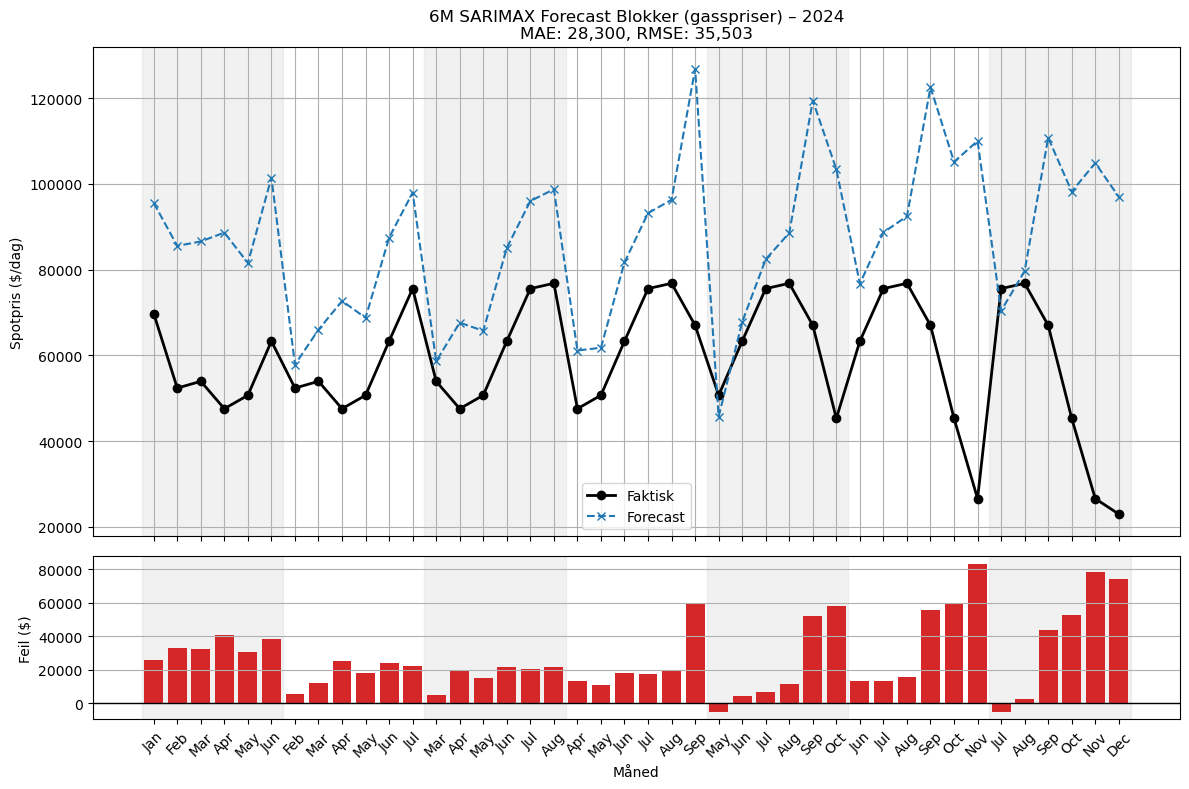

In [68]:
# === 1. Endre til 6M forecast ===
forecast_start_dates = pd.date_range(start="2024-01-01", end="2024-07-01", freq="MS")  # siste startdato = juli

forecasts_6m = []
actuals_6m = []
forecast_months_6m = []

# === 2. Rullerende 6M forecast med SARIMAX og log-transformasjon ===
for start_date in forecast_start_dates:
    train_end = start_date - pd.DateOffset(months=1)
    train_df = df[:train_end]
    forecast_period = pd.date_range(start=start_date, periods=6, freq="MS")

    if not set(forecast_period).issubset(df.index):
        break

    actual = df.loc[forecast_period, target].dropna()
    if len(actual) < 6:
        break

    log_train_target = np.log(train_df[target].dropna())
    exog_train = train_df.loc[log_train_target.index, exog_vars]
    exog_test = df.loc[forecast_period, exog_vars]

    model = SARIMAX(
        log_train_target,
        exog=exog_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    forecast_log = model.forecast(steps=6, exog=exog_test)
    forecast = np.exp(forecast_log)

    forecasts_6m.extend(forecast)
    actuals_6m.extend(actual.values)
    forecast_months_6m.extend(forecast_period)

# === 3. Evaluer og visualiser 6M forecast ===
x = np.arange(1, len(forecast_months_6m) + 1)
month_labels = [d.strftime('%b') for d in forecast_months_6m]
residuals = np.array(forecasts_6m) - np.array(actuals_6m)
mae_6m = mean_absolute_error(actuals_6m, forecasts_6m)
rmse_6m = np.sqrt(mean_squared_error(actuals_6m, forecasts_6m))

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Toppanel: Forecast vs faktisk
axes[0].plot(x, actuals_6m, marker='o', label="Faktisk", color='black', linewidth=2)
axes[0].plot(x, forecasts_6m, marker='x', linestyle='--', label="Forecast", color='tab:blue')

# Skyggelagte 6M blokker
block_len = 6
block_count = len(x) // block_len
for i in range(block_count):
    if i % 2 == 0:
        axes[0].axvspan(i * block_len + 0.5, (i + 1) * block_len + 0.5, color='lightgray', alpha=0.3)
        axes[1].axvspan(i * block_len + 0.5, (i + 1) * block_len + 0.5, color='lightgray', alpha=0.3)

axes[0].set_title(f"6M SARIMAX Forecast Blokker (gasspriser) – 2024\nMAE: {int(mae_6m):,}, RMSE: {int(rmse_6m):,}")
axes[0].set_ylabel("Spotpris ($/dag)")
axes[0].legend()
axes[0].grid(True)

# Bunnpanel: Residualer
axes[1].bar(x, residuals, color='tab:red')
axes[1].axhline(0, color='black', linewidth=1)
axes[1].set_ylabel("Feil ($)")
axes[1].set_xlabel("Måned")
axes[1].grid(True, axis='y')
axes[1].set_xticks(x)
axes[1].set_xticklabels(month_labels, rotation=45)

plt.tight_layout()
plt.show()


C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


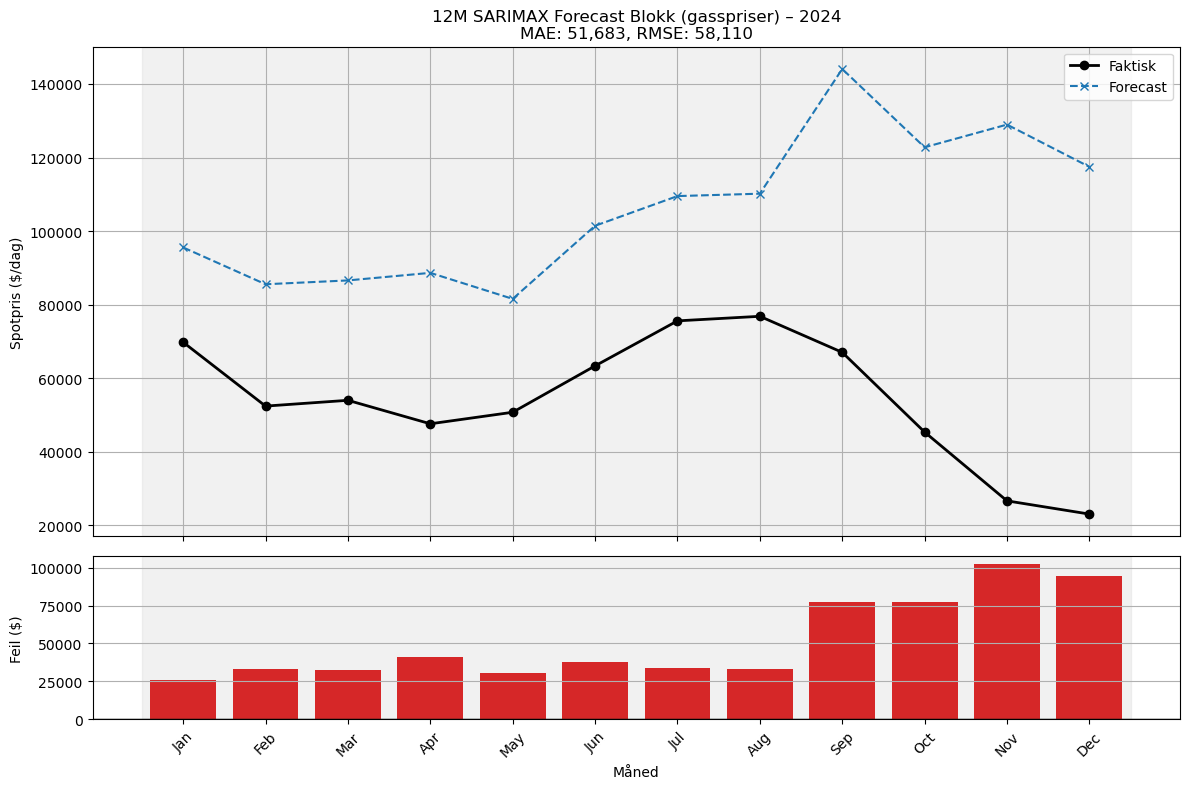

In [70]:
# === 1. Sett opp 12M forecastperiode ===
start_date_12m = pd.to_datetime("2024-01-01")
forecast_period_12m = pd.date_range(start=start_date_12m, periods=12, freq="MS")

train_end_12m = start_date_12m - pd.DateOffset(months=1)
train_df_12m = df[:train_end_12m]
actual_12m = df.loc[forecast_period_12m, target].dropna()

# === 2. Kjør SARIMAX 12M forecast hvis faktisk data er tilgjengelig ===
if len(actual_12m) == 12:
    log_train_target = np.log(train_df_12m[target].dropna())
    exog_train = train_df_12m.loc[log_train_target.index, exog_vars]
    exog_test = df.loc[forecast_period_12m, exog_vars]

    model_12m = SARIMAX(
        log_train_target,
        exog=exog_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    forecast_log_12m = model_12m.forecast(steps=12, exog=exog_test)
    forecast_12m = np.exp(forecast_log_12m)

    # === 3. Evaluer og visualiser 12M forecast ===
    residuals_12m = forecast_12m - actual_12m.values
    mae_12m = mean_absolute_error(actual_12m.values, forecast_12m)
    rmse_12m = np.sqrt(mean_squared_error(actual_12m.values, forecast_12m))
    x = np.arange(1, 13)
    month_labels = [d.strftime('%b') for d in forecast_period_12m]

    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    axes[0].plot(x, actual_12m.values, marker='o', label="Faktisk", color='black', linewidth=2)
    axes[0].plot(x, forecast_12m, marker='x', linestyle='--', label="Forecast", color='tab:blue')
    axes[0].axvspan(0.5, 12.5, color='lightgray', alpha=0.3)
    axes[1].axvspan(0.5, 12.5, color='lightgray', alpha=0.3)

    axes[0].set_title(f"12M SARIMAX Forecast Blokk (gasspriser) – 2024\nMAE: {int(mae_12m):,}, RMSE: {int(rmse_12m):,}")
    axes[0].set_ylabel("Spotpris ($/dag)")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].bar(x, residuals_12m, color='tab:red')
    axes[1].axhline(0, color='black', linewidth=1)
    axes[1].set_ylabel("Feil ($)")
    axes[1].set_xlabel("Måned")
    axes[1].grid(True, axis='y')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(month_labels, rotation=45)

    plt.tight_layout()
    plt.show()
else:
    print("Ikke nok faktisk data tilgjengelig for hele 2024.")


C:\Users\Eier\AppData\Local\Temp\ipykernel_20108\3639536012.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("cleandata.csv", parse_dates=["Date"], dayfirst=True)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Eier\anaconda3\Lib\site-packages\s


📊 SARIMAX Forecast Evaluation – Alternativ 3 (Full modell):
  Horizon       MAE      RMSE
3     12M  51297.11  54932.49
0      1M   7774.42  10266.07
1      3M  13793.61  17227.13
2      6M  14180.35  18658.48


C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


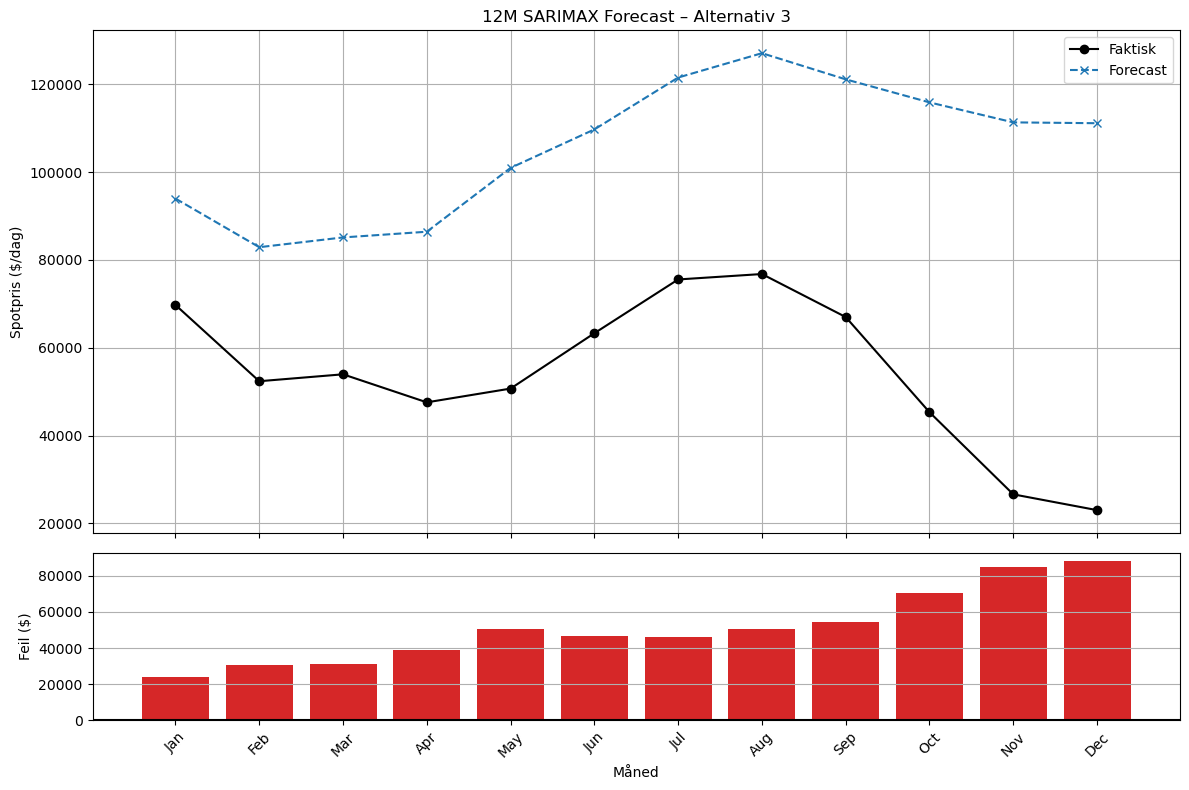

In [78]:
# === SARIMAX forecast: Alternativ 3 (Gass + Flåte + Orderbok + Nybygg) ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# === 1. Last inn og klargjør data ===
df = pd.read_csv("cleandata.csv", parse_dates=["Date"], dayfirst=True)
df.set_index("Date", inplace=True)
df.rename(columns={
    'LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)': 'Spot_Rate',
    'Global price of Natural Gas, Asia (start month, MMBTU)': 'JKM',
    'Global price of Natural Gas, EU (start month, MMBTU)': 'TTF',
    'Global price of Natural Gas, US Henry Hub (start month, MMBTU)': 'NBP',
    'LNG Shipping Capacity (CBM)': 'Active_LNG_Fleet',
    'LNG Orderbook (start month, CBM)': 'Orderbook',
    'LNG Carrier Newbuilding Prices (end month, $m)': 'Newbuilding_Price'
}, inplace=True)

# Clean up column names (e.g., remove line breaks like \n)
df.columns = df.columns.str.replace('\n', ' ', regex=True).str.strip()

# === 2. Lag proxy for utilization (%)
df["Utilization"] = df["Spot_Rate"] / df["Active_LNG_Fleet"]
df["Utilization"] = df["Utilization"] / df["Utilization"].max() * 100

# === 3. Definer exog-variabler og SARIMA-parametre
exog_vars = ["JKM", "TTF", "NBP", "Spread EU-US", "Spread ASIA-US", "Spread ASIA-EU", "Active_LNG_Fleet", "Utilization", "Orderbook", "Newbuilding_Price"]
order = (1, 1, 2)
seasonal_order = (1, 0, 0, 12)

# === 4. Funksjon for rolling SARIMAX forecast
def rolling_sarimax_forecast(df, target, exog_vars, start_date, horizon_months):
    forecast_dates = pd.date_range(start=start_date, end="2024-12-01", freq="MS")
    forecast_dates = forecast_dates[:-(horizon_months-1)] if horizon_months > 1 else forecast_dates

    forecasts, actuals, forecast_months = [], [], []

    for start_date in forecast_dates:
        train_end = start_date - pd.DateOffset(months=1)
        train_df = df[:train_end]
        forecast_period = pd.date_range(start=start_date, periods=horizon_months, freq="MS")

        if not set(forecast_period).issubset(df.index):
            break

        actual = df.loc[forecast_period, target].dropna()
        if len(actual) < horizon_months:
            break

        log_train = np.log(train_df[target].dropna())
        exog_train = train_df.loc[log_train.index, exog_vars]
        exog_test = df.loc[forecast_period, exog_vars]

        model = SARIMAX(
            log_train,
            exog=exog_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        forecast_log = model.forecast(steps=horizon_months, exog=exog_test)
        forecast = np.exp(forecast_log)

        forecasts.extend(forecast)
        actuals.extend(actual.values)
        forecast_months.extend(forecast_period)

    return forecasts, actuals, forecast_months

# === 5. Kjør 1M, 3M, 6M
results = {}
for horizon in [1, 3, 6]:
    forecasts, actuals, months = rolling_sarimax_forecast(
        df, target="Spot_Rate", exog_vars=exog_vars,
        start_date=pd.to_datetime("2024-01-01"),
        horizon_months=horizon
    )
    results[f"{horizon}M"] = {"forecast": forecasts, "actual": actuals, "months": months}

# === 6. Kjør 12M separat
forecast_period_12m = pd.date_range(start="2024-01-01", periods=12, freq="MS")
train_df_12m = df[:'2023-12-01']
actual_12m = df.loc[forecast_period_12m, "Spot_Rate"].dropna()

if len(actual_12m) == 12:
    log_train = np.log(train_df_12m["Spot_Rate"].dropna())
    exog_train = train_df_12m.loc[log_train.index, exog_vars]
    exog_test = df.loc[forecast_period_12m, exog_vars]

    model_12m = SARIMAX(
        log_train,
        exog=exog_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    forecast_log_12m = model_12m.forecast(steps=12, exog=exog_test)
    forecast_12m = np.exp(forecast_log_12m)

    results["12M"] = {
        "forecast": forecast_12m,
        "actual": actual_12m.values,
        "months": forecast_period_12m
    }

# === 7. Evaluer resultater
evaluation = []
for key, res in results.items():
    mae = mean_absolute_error(res["actual"], res["forecast"])
    rmse = np.sqrt(mean_squared_error(res["actual"], res["forecast"]))
    evaluation.append({
        "Horizon": key,
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2)
    })

eval_df = pd.DataFrame(evaluation).sort_values("Horizon")
print("\n📊 SARIMAX Forecast Evaluation – Alternativ 3 (Full modell):")
print(eval_df)

# === 8. Plot en valgt horisont (endre gjerne fra "6M" til "1M", "3M" eller "12M")
selected = "12M"
res = results[selected]

x = np.arange(1, len(res["months"]) + 1)
month_labels = [d.strftime('%b') for d in res["months"]]
residuals = np.array(res["forecast"]) - np.array(res["actual"])

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
axes[0].plot(x, res["actual"], marker='o', label="Faktisk", color='black')
axes[0].plot(x, res["forecast"], marker='x', linestyle='--', label="Forecast", color='tab:blue')
axes[0].set_title(f"{selected} SARIMAX Forecast – Alternativ 3")
axes[0].set_ylabel("Spotpris ($/dag)")
axes[0].legend()
axes[0].grid(True)

axes[1].bar(x, residuals, color='tab:red')
axes[1].axhline(0, color='black')
axes[1].set_ylabel("Feil ($)")
axes[1].set_xlabel("Måned")
axes[1].grid(True, axis='y')
axes[1].set_xticks(x)
axes[1].set_xticklabels(month_labels, rotation=45)

plt.tight_layout()
plt.show()


C:\Users\Eier\AppData\Local\Temp\ipykernel_20108\793934006.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("cleandata.csv", parse_dates=["Date"], dayfirst=True)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Eier\anaconda3\Lib\site-packages\s


📊 SARIMAX Forecast Evaluation – Alternativ 2 (Gass + Flåtekapasitet):
  Horizon       MAE      RMSE
3     12M  16837.16  19630.17
0      1M   7236.72   8780.67
1      3M  12154.48  15082.51
2      6M  13141.00  15564.45


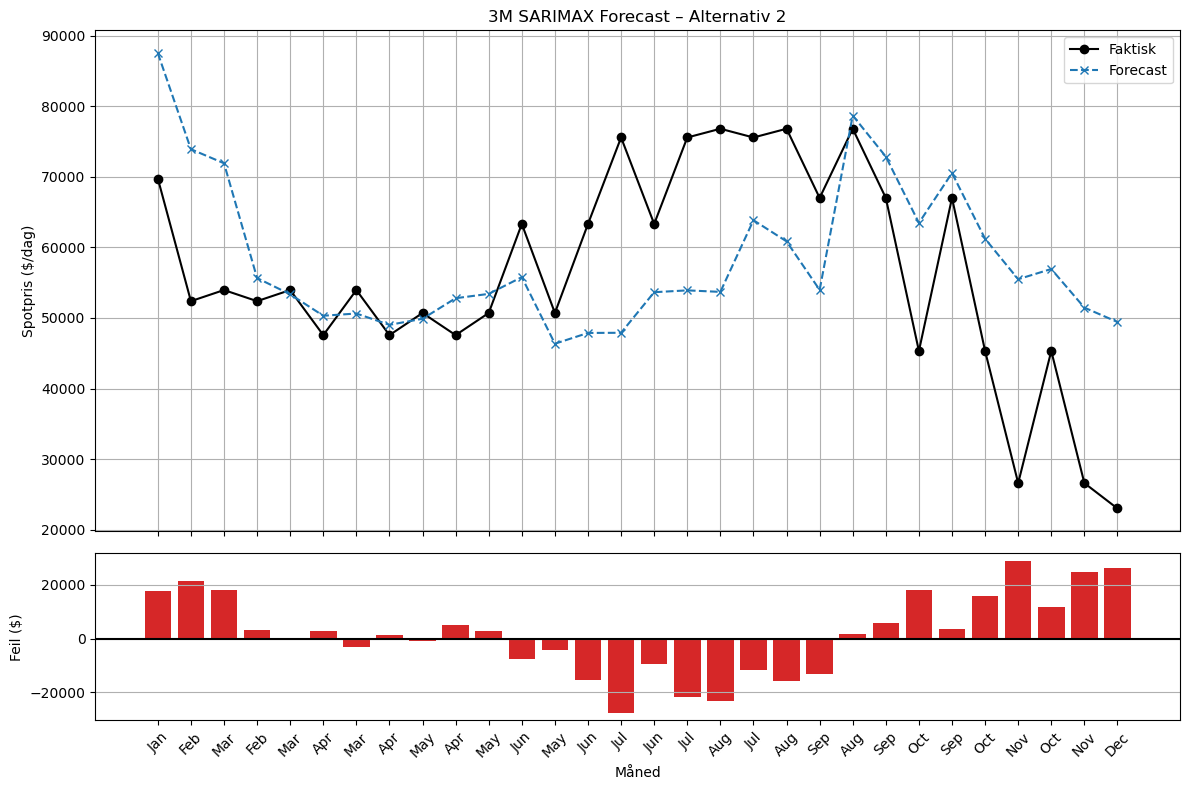

In [76]:
# === SARIMAX forecast: Alternativ 2 (Gasspriser + Flåtekapasitet) ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error


# === 1. Last inn og klargjør data ===
df = pd.read_csv("cleandata.csv", parse_dates=["Date"], dayfirst=True)
df.set_index("Date", inplace=True)
df.rename(columns={
    'LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)': 'Spot_Rate',
    'Global price of Natural Gas, Asia (start month, MMBTU)': 'JKM',
    'Global price of Natural Gas, EU (start month, MMBTU)': 'TTF',
    'Global price of Natural Gas, US Henry Hub (start month, MMBTU)': 'NBP',
    'LNG Shipping Capacity (CBM)': 'Active_LNG_Fleet'
}, inplace=True)

# Clean up column names (e.g., remove line breaks like \n)
df.columns = df.columns.str.replace('\n', ' ', regex=True).str.strip()

# === 2. Lag proxy for utilization (%)
df["Utilization"] = df["Spot_Rate"] / df["Active_LNG_Fleet"]
df["Utilization"] = df["Utilization"] / df["Utilization"].max() * 100

# === 3. Definer exog-variabler og parametere
exog_vars = ["JKM", "TTF", "NBP", "Spread EU-US", "Spread ASIA-US", "Spread ASIA-EU", "Active_LNG_Fleet", "Utilization"]
order = (1, 1, 2)
seasonal_order = (1, 0, 0, 12)

# === 4. Funksjon for rolling SARIMAX forecast
def rolling_sarimax_forecast(df, target, exog_vars, start_date, horizon_months):
    forecast_dates = pd.date_range(start=start_date, end="2024-12-01", freq="MS")
    forecast_dates = forecast_dates[:-(horizon_months-1)] if horizon_months > 1 else forecast_dates

    forecasts, actuals, forecast_months = [], [], []

    for start_date in forecast_dates:
        train_end = start_date - pd.DateOffset(months=1)
        train_df = df[:train_end]
        forecast_period = pd.date_range(start=start_date, periods=horizon_months, freq="MS")

        if not set(forecast_period).issubset(df.index):
            break

        actual = df.loc[forecast_period, target].dropna()
        if len(actual) < horizon_months:
            break

        log_train = np.log(train_df[target].dropna())
        exog_train = train_df.loc[log_train.index, exog_vars]
        exog_test = df.loc[forecast_period, exog_vars]

        model = SARIMAX(
            log_train,
            exog=exog_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        forecast_log = model.forecast(steps=horizon_months, exog=exog_test)
        forecast = np.exp(forecast_log)

        forecasts.extend(forecast)
        actuals.extend(actual.values)
        forecast_months.extend(forecast_period)

    return forecasts, actuals, forecast_months

# === 5. Kjør forecasts for 1M, 3M, 6M, 12M
results = {}

# Rolling forecasts
for horizon in [1, 3, 6]:
    forecasts, actuals, months = rolling_sarimax_forecast(
        df, target="Spot_Rate", exog_vars=exog_vars,
        start_date=pd.to_datetime("2024-01-01"),
        horizon_months=horizon
    )
    results[f"{horizon}M"] = {"forecast": forecasts, "actual": actuals, "months": months}

# 12M static forecast
forecast_period_12m = pd.date_range(start="2024-01-01", periods=12, freq="MS")
train_df_12m = df[:'2023-12-01']
actual_12m = df.loc[forecast_period_12m, "Spot_Rate"].dropna()

if len(actual_12m) == 12:
    log_train = np.log(train_df_12m["Spot_Rate"].dropna())
    exog_train = train_df_12m.loc[log_train.index, exog_vars]
    exog_test = df.loc[forecast_period_12m, exog_vars]

    model_12m = SARIMAX(
        log_train,
        exog=exog_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    forecast_log_12m = model_12m.forecast(steps=12, exog=exog_test)
    forecast_12m = np.exp(forecast_log_12m)

    results["12M"] = {
        "forecast": forecast_12m,
        "actual": actual_12m.values,
        "months": forecast_period_12m
    }
# === 7. Evaluer og vis resultater
evaluation = []
for key, res in results.items():
    mae = mean_absolute_error(res["actual"], res["forecast"])
    rmse = np.sqrt(mean_squared_error(res["actual"], res["forecast"]))
    evaluation.append({
        "Horizon": key,
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2)
    })

eval_df = pd.DataFrame(evaluation).sort_values("Horizon")
print("\n📊 SARIMAX Forecast Evaluation – Alternativ 2 (Gass + Flåtekapasitet):")
print(eval_df)

# === 8. (Valgfritt) Plot en av forecastene
import matplotlib.pyplot as plt

selected = "3M"  # endre til "1M", "3M", "6M" eller "12M"
res = results[selected]

x = np.arange(1, len(res["months"]) + 1)
month_labels = [d.strftime('%b') for d in res["months"]]
residuals = np.array(res["forecast"]) - np.array(res["actual"])

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
axes[0].plot(x, res["actual"], marker='o', label="Faktisk", color='black')
axes[0].plot(x, res["forecast"], marker='x', linestyle='--', label="Forecast", color='tab:blue')
axes[0].set_title(f"{selected} SARIMAX Forecast – Alternativ 2")
axes[0].set_ylabel("Spotpris ($/dag)")
axes[0].legend()
axes[0].grid(True)

axes[1].bar(x, residuals, color='tab:red')
axes[1].axhline(0, color='black')
axes[1].set_ylabel("Feil ($)")
axes[1].set_xlabel("Måned")
axes[1].grid(True, axis='y')
axes[1].set_xticks(x)
axes[1].set_xticklabels(month_labels, rotation=45)

plt.tight_layout()
plt.show()